In [96]:
import warnings

import pandas as pd
import pendulum as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
from IPython.display import display, Latex

plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
)

warnings.filterwarnings("ignore")

In [52]:
# Function get data from yahoo finance
def get_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)[['Close','Adj Close']]
    data['log return'] = np.log(data['Close']/data['Close'].shift(1))
    return data

# Heston Model - Monte Carlo Simulation

## Euler discretization scheme

- Discretization of the variance process $v_t$:

**$$v_{t + dt} = v_t + \kappa(\theta - v_t) dt + \sigma\sqrt{v_{t}dt}Z_v$$**

Where $Z_v$ is a standard normal random variable - $Z_v \sim \mathcal{N}(0,1)$

To avoid negative variance, we can replace $v_t$ by $\max \{0, v_t\}$, this is the full truncation scheme. The reflection scheme is also possible, where we replace $v_t$ by |$v_t$|.

- Discretization of the asset price process $ ln(S_t)$:

**$$ln(S_{t + dt}) = ln(S_t) + (r - \frac{1}{2} v_t)dt + \sqrt{v_{t}dt}Z_S$$**
**$$S_{t + dt} = S_t \exp((r - \frac{1}{2} v_t)dt + \sqrt{v_{t}dt}Z_S)$$**

Where $Z_S$ is a standard normal random variable ($Z_S \sim \mathcal{N}(0,1)$) that has corrolation $\rho$ with $Z_v$

In [53]:
# Function Heston model - Need work
def heston_volatility_process(
    steps, number_of_samples, kappa, theta, sigma, rho, v0, T, r, s0, return_vol=False, scheme='full truncation'
):
    dt = T / steps
    size = (number_of_samples, steps)
    prices = np.zeros(size)
    v = np.zeros(size)
    s_t = s0
    v_t = v0
    for i in range(steps):
        Z = np.random.multivariate_normal(
            np.array([0, 0]), cov=np.array([[1, rho], [rho, 1]]), size=number_of_samples
        )
        s_t = s_t * (np.exp((r - 0.5 * v_t) * dt + np.sqrt(v_t * dt) * Z[:, 0]))
        if scheme == 'full truncation':
            v_t = np.maximum(v_t + kappa * (theta - v_t) *
                             dt + sigma * np.sqrt(v_t * dt) * Z[:, 1], 0)
        elif scheme == 'reflection':
            v_t = np.abs(v_t + kappa * (theta - v_t) * dt +
                         sigma * np.sqrt(v_t * dt) * Z[:, 1])
        else:
            raise ValueError('scheme must be either "full truncation" or "reflection"')
        v[:, i] = v_t
        prices[:, i] = s_t

    if return_vol:
        return prices.T, v.T
    return prices.T

In [54]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma, r, T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations
    
    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])
    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)
    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))
    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    
    return S, v

In [55]:
steps = 252
number_of_samples = 1000
kappa = 0.7985 # mean reversion factor
theta = 0.06533 # long run average variance of price
sigma = .1136 # volatility of volatility
rho = -0.2930 # correlation between the two brownian motions
v0 = .02879 # initial variance
T = 1 # time horizon
r = 0.0533 # risk free rate
s0 = 4766.18 # initial stock price

In [56]:
test = heston_model_sim(s0, v0, rho, kappa, theta, sigma, r, T, steps, number_of_samples)
test1= heston_volatility_process(steps, number_of_samples, kappa, theta, sigma, rho, v0, T, r, s0, return_vol=True)

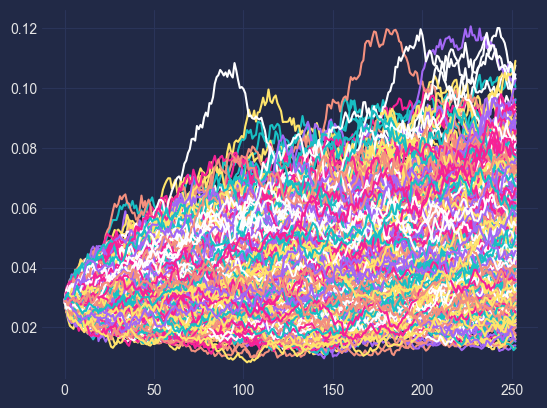

In [57]:
plt.plot(test[1])
plt.show()

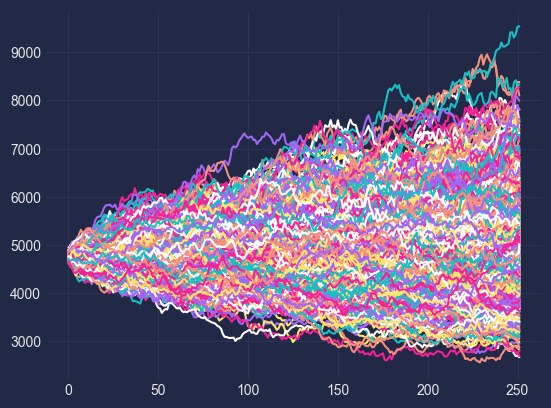

In [58]:
plt.plot(test1[0])
plt.show()

In [103]:
# Importing the data from Yahoo Finance
end_date = pm.today()
start_date = end_date - pm.duration(years=5)

stock_1 = get_data("^SPX", start_date, end_date)
stock_1 = stock_1.sort_values(by="Date", ascending=False)

# Remove NaN values
stock_1 = stock_1.dropna()

[*********************100%%**********************]  1 of 1 completed


In [104]:
stock_1

,Close,Adj Close,log return
Date,,,
2024-04-25,5048.419922,5048.419922,-0.004587
2024-04-24,5071.629883,5071.629883,0.000213
2024-04-23,5070.549805,5070.549805,0.011894
2024-04-22,5010.600098,5010.600098,0.008693
2024-04-19,4967.229980,4967.229980,-0.008797
...,...,...,...
2019-05-02,2917.520020,2917.520020,-0.002126
2019-05-01,2923.729980,2923.729980,-0.007530
2019-04-30,2945.830078,2945.830078,0.000951


In [131]:
# Return array of stock prices
returns = np.array(stock_1["log return"].values)
returns


array([-0.00458693,  0.00021299,  0.01189357, ...,  0.00095096,
        0.00107095,  0.00467435])

In [132]:
def log_likelihood_computation(returns, params):
    theta, kappa, sigma,rho, mu = [param for param in params.values()]
    residuals = returns - mu
    expected_variance = ((returns - mu) ** 2) + kappa * (theta - (returns - mu)**2)
    log_likelihood_part1 =  1 / (2 * np.pi * np.sqrt(expected_variance) * sigma * np.sqrt(1 - rho**2))
    log_likelihood_part2 = np.exp(-((((residuals / np.sqrt(expected_variance))**2) 
                                    - 2 * rho * (residuals / np.sqrt(expected_variance)) * 
                                    (((residuals**2 - expected_variance) / sigma)) + 
                                    (((residuals**2 - expected_variance) / sigma)**2)) / (2 * (1 - rho**2))))
    log_likelihood = np.log(log_likelihood_part1 * log_likelihood_part2)
    return log_likelihood

def log_likelihood(x, returns):
    theta, kappa, sigma,rho, mu = [param for param in x]
    
    lg = np.sum(log_likelihood_computation(returns, {"theta": theta, "kappa": kappa, "sigma": sigma, "rho": rho, "mu": mu}))
    
    return -lg

In [185]:
params = {"theta": {"x0": 0.9, "lbud": [0,None]},
          "kappa": {"x0": 0.9, "lbud": [0,None]},
          "sigma": {"x0": 0.9, "lbud": [0,None]},
          "rho": {"x0": 0, "lbud": [-1,1]},
          "mu": {"x0": 0.9, "lbud": [0,None]}
          }

x0 = [param["x0"] for key, param in params.items()]
bnds = [params['lbud'] for key, params in params.items()]

In [192]:
result = minimize(log_likelihood, x0, args=(returns), bounds=bnds, method='SLSQP')

In [193]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -7103.489731915059
       x: [ 2.974e-02  2.079e-01  2.375e-02  9.756e-01  2.510e-02]
     nit: 13
     jac: [-2.357e+00  1.974e+02  6.146e+04 -1.347e+04  1.483e+04]
    nfev: 80
    njev: 9

In [194]:
theta_hat = r'$\hat{\theta} = '+str(result.x[0])+'$'
kappa_hat = r'$\hat{\kappa} = '+str(result.x[1])+'$'
sigma_hat = r'$\hat{\sigma} = '+str(result.x[2])+'$'
rho_hat = r'$\hat{\rho} = '+str(result.x[3])+'$'
mu_hat = r'$\hat{\mu} = '+str(result.x[4])+'$'

display(Latex(theta_hat))
display(Latex(kappa_hat))
display(Latex(sigma_hat))
display(Latex(rho_hat))
display(Latex(mu_hat))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [195]:
test2= heston_volatility_process(steps, number_of_samples, result.x[1], result.x[0], result.x[2], result.x[3], v0, T, r, s0, return_vol=True)

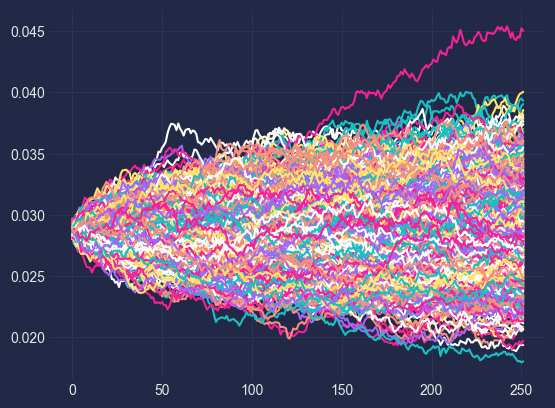

In [196]:
plt.plot(test2[1])
plt.show()